<a href="https://colab.research.google.com/github/Plabanzeoanai/NLP/blob/main/Huggingface_Sentence_transformer__classify_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks.

In [18]:
!pip install transformers

     |████████████████████████████████| 2.5 MB 13.1 MB/s 
     |████████████████████████████████| 3.3 MB 60.3 MB/s 
     |████████████████████████████████| 895 kB 52.4 MB/s 


## sentence-transformers/bert-base-nli-mean-tokens
This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.

In [19]:
!pip install -U sentence-transformers

     |████████████████████████████████| 85 kB 3.9 MB/s 
     |████████████████████████████████| 1.2 MB 25.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126709 sha256=e33a18dd4a38da229def2eeeb0c5207605c9936c0734fe68f2678b8140bd4f25
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers


## Sentence Transformers -Distilbert

In [53]:
import pandas as pd
import numpy as np
from sklearn.metrics import  (auc,confusion_matrix,roc_auc_score,roc_curve,f1_score,accuracy_score)
from sklearn.model_selection import *
from yellowbrick.classifier import (ConfusionMatrix,ROCAUC,)
from yellowbrick.model_selection import (LearningCurve,)

import warnings
warnings.filterwarnings('ignore')

## Read Training Data

In [3]:
!wget "https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label"  -O newfile.txt

--2021-07-22 09:25:07--  https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label
Resolving cogcomp.seas.upenn.edu (cogcomp.seas.upenn.edu)... 158.130.57.77
Connecting to cogcomp.seas.upenn.edu (cogcomp.seas.upenn.edu)|158.130.57.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335858 (328K)
Saving to: ‘newfile.txt’

newfile.txt         100%[===================>] 327.99K  1.00MB/s    in 0.3s    

2021-07-22 09:25:07 (1.00 MB/s) - ‘newfile.txt’ saved [335858/335858]



## Seggregate Label and Text

In [4]:
label = []
question = []
with open("/content/newfile.txt","r",encoding="ISO-8859-1") as f:
  for line in f.readlines():
    text = line.split(":")
    label.append(text[0])
    question.append(text[1])

## Get the data into DataFrame

In [11]:
train = pd.DataFrame({'Question':question,'Label':label})

In [12]:
train.head()

,Question,Label
0,manner How did serfdom develop in and then lea...,DESC
1,cremat What films featured the character Popey...,ENTY
2,manner How can I find a list of celebrities ' ...,DESC
3,animal What fowl grabs the spotlight after the...,ENTY
4,exp What is the full form of .com ?\n,ABBR


## Data Decription

In [7]:
train.shape

(5452, 2)

## Label Distribution

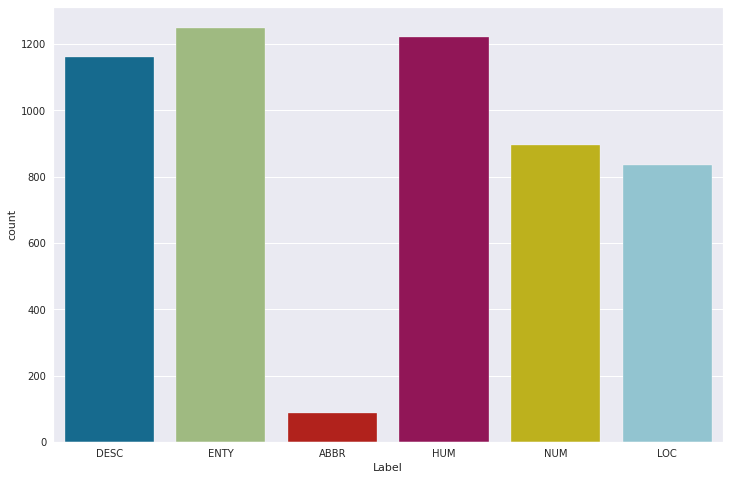

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.countplot(train['Label'])
plt.show()

## Define a function to map the labels DESC or FACT

In [14]:
def map_labels(x):
  if x == "DESC":
    return "DESC"
  else:
    return "FACT"

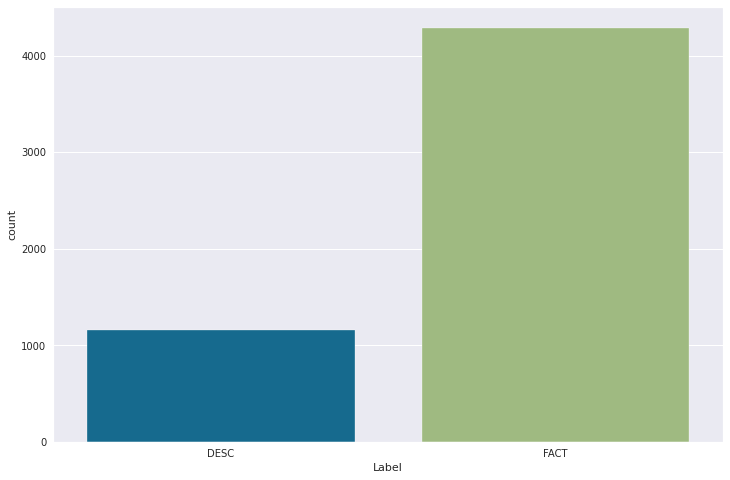

In [15]:
train['Label'] = train['Label'].map(map_labels)
plt.figure(figsize=(12,8))
sns.countplot(train['Label'])
plt.show()

## Using Transformer Pipeline

In [16]:
sentences = train['Question'].values.tolist()

In [21]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/distilbert-base-nli-mean-tokens')
embeddings = model.encode(sentences)
print(embeddings)


[[-1.280514   -0.47905657 -0.07459374 ... -0.6903947   0.65552545
   0.42993134]
 [ 0.05076507 -0.23158778  0.44918114 ... -0.94587755  0.58218163
   0.16936493]
 [ 0.16578262  0.08628513  0.99605775 ... -1.4010978  -0.16692457
  -0.66698945]
 ...
 [-0.48092666 -0.33031234  0.9020131  ... -0.71855974  0.37934303
  -0.6125831 ]
 [ 0.16263327  0.17402275  0.30849588 ... -0.47458428  0.43626916
  -0.6093793 ]
 [-0.23205915 -0.50195086 -0.17518842 ... -0.38250554  0.41391855
  -0.6617368 ]]


* The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.

In [22]:
train_vector = pd.DataFrame(np.array(embeddings))

In [23]:
train_vector.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-1.280514,-0.479057,-0.074594,-1.078832,0.555026,-0.304828,0.710984,0.278825,0.129274,0.484494,0.194379,0.099252,0.048627,0.641369,0.453776,-0.550658,-0.685677,0.614255,-0.001949,-0.382198,-0.034112,0.072871,0.070514,-0.182452,-0.672063,-0.203226,0.207312,-0.494412,-0.015926,0.394312,0.036818,0.289581,0.572028,0.346302,-0.048939,0.285915,0.699641,0.078200,-0.658135,-0.720307,...,-0.032483,-1.037481,-0.430439,0.345353,-0.443688,0.326153,0.006781,-0.017737,0.361109,0.084457,-0.220593,-0.326400,0.109499,-0.313511,0.126476,-1.023944,0.019120,0.276654,0.090974,-0.871337,0.066085,0.055102,0.710251,0.815904,0.116723,-0.763052,-0.191135,-0.117060,-0.917495,0.238746,-0.721925,-0.708831,0.919504,0.014721,-0.218465,-0.707999,-0.060461,-0.690395,0.655525,0.429931
1,0.050765,-0.231588,0.449181,-0.434117,-0.437005,-0.025377,0.901859,0.299691,0.397571,0.363239,0.813872,-0.242552,-0.046876,0.664556,0.063659,-0.778085,-0.464536,0.818348,0.217839,-0.682175,-0.048325,0.305595,0.005277,-0.105053,-0.850086,-0.180318,0.599913,-0.693823,-0.018519,0.129674,0.459312,0.366444,-0.351863,0.442381,0.333915,-0.367255,1.370850,-0.371237,-0.394274,0.127976,...,-0.759870,-0.319705,-0.320549,0.269263,-0.234702,0.203369,0.363199,0.800868,0.343576,0.986706,-0.211597,0.346223,-0.544377,0.259784,-0.261309,-0.354508,-0.033133,0.439806,0.176840,-0.155800,-1.046833,-0.140347,0.822187,1.090696,-0.127105,-1.281975,0.121476,-0.035387,-1.036540,-0.455563,-1.028529,-0.167688,-0.617333,-0.128335,-0.154140,0.052782,0.287510,-0.945878,0.582182,0.169365
2,0.165783,0.086285,0.996058,-0.007493,-0.062556,-0.447119,1.157736,-0.594608,-0.278915,0.288760,-0.755688,0.518912,-0.589018,-0.218036,-0.299750,-0.588890,-1.044726,0.417886,-0.516429,-0.688118,0.293211,0.023602,-0.186256,0.847153,-0.451656,0.414897,0.153552,-0.524880,0.480987,0.345679,0.525045,0.589052,-0.483123,0.143384,0.049669,-0.625910,1.300623,-0.494312,0.039376,-0.539757,...,-0.288382,0.158903,-0.675779,-0.603539,-0.569769,0.099041,0.707026,0.829515,-0.109335,0.677547,0.197822,0.223959,-0.297395,-0.826129,-0.965579,-0.218842,1.487624,-0.247483,-0.609409,-0.065343,-0.464756,-0.134924,1.308985,0.461915,-0.319942,-0.315665,-0.672881,0.423251,-1.299873,-0.380740,-1.354729,-0.239816,-0.171938,0.529478,-0.135893,1.097948,-0.018599,-1.401098,-0.166925,-0.666989
3,-0.178117,-0.473958,0.048357,-1.291486,-0.028839,0.348842,-0.046128,0.052367,-0.436607,1.082325,1.379477,0.269814,-0.224944,0.555075,0.196508,-1.012059,-0.139680,0.013312,0.595400,-0.556999,-0.128182,0.313684,-0.397969,0.625162,-1.139045,0.605110,0.438818,-0.294600,-0.015436,-0.200387,-0.028176,0.543886,-0.501193,0.160218,-0.207827,-0.185351,0.511595,-0.588324,0.523014,-0.696837,...,-1.323598,-0.134631,-0.420599,-0.185516,-0.183404,0.793519,0.255796,0.518475,0.655393,0.389528,-0.159402,0.155687,-0.318774,-0.182897,-0.584351,-1.437036,0.627801,0.532542,0.662939,0.678888,-0.622288,0.319154,0.996853,0.696456,0.012059,-0.387256,0.541324,0.047869,-0.789448,-0.599024,-0.941752,0.158490,-0.710274,0.030269,0.281971,0.180029,0.274251,-0.035900,1.007164,-0.209413
4,-0.341517,-0.614352,0.075420,-0.381870,-0.037142,-0.639595,1.047396,1.109776,-0.500967,-0.308551,-0.026306,0.817466,0.180812,0.402919,0.446856,-0.506134,-0.852798,0.875699,-0.568851,-0.948410,0.342488,-0.257154,-0.041045,1.054365,0.182189,0.183331,0.685496,-0.191475,-0.196328,-0.376523,0.161194,-0.232624,-0.124186,0.408084,0.532743,-0.697111,-0.076796,-0.269128,-0.596582,-0.246367,...,-0.935546,0.314507,-0.171532,-0.507654,-0.372031,0.384393,-0.427786,-0.062957,0.381885,-0.210031,-0.373227,0.138791,-0.295719,-0.431427,-0.521123,0.406644,0.222613,-0.539807,-0.619525,0.157020,-0.941711,-0.363686,0.716169,-0.360151,-0.008979,-0.696636,-0.872138,0.

## Concat genereated word Vector aloing with the original text and label

In [24]:
final_train = pd.concat((train_vector,train),axis=1)

In [25]:
final_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Question,Label
0,-1.280514,-0.479057,-0.074594,-1.078832,0.555026,-0.304828,0.710984,0.278825,0.129274,0.484494,0.194379,0.099252,0.048627,0.641369,0.453776,-0.550658,-0.685677,0.614255,-0.001949,-0.382198,-0.034112,0.072871,0.070514,-0.182452,-0.672063,-0.203226,0.207312,-0.494412,-0.015926,0.394312,0.036818,0.289581,0.572028,0.346302,-0.048939,0.285915,0.699641,0.078200,-0.658135,-0.720307,...,-0.430439,0.345353,-0.443688,0.326153,0.006781,-0.017737,0.361109,0.084457,-0.220593,-0.326400,0.109499,-0.313511,0.126476,-1.023944,0.019120,0.276654,0.090974,-0.871337,0.066085,0.055102,0.710251,0.815904,0.116723,-0.763052,-0.191135,-0.117060,-0.917495,0.238746,-0.721925,-0.708831,0.919504,0.014721,-0.218465,-0.707999,-0.060461,-0.690395,0.655525,0.429931,manner How did serfdom develop in and then lea...,DESC
1,0.050765,-0.231588,0.449181,-0.434117,-0.437005,-0.025377,0.901859,0.299691,0.397571,0.363239,0.813872,-0.242552,-0.046876,0.664556,0.063659,-0.778085,-0.464536,0.818348,0.217839,-0.682175,-0.048325,0.305595,0.005277,-0.105053,-0.850086,-0.180318,0.599913,-0.693823,-0.018519,0.129674,0.459312,0.366444,-0.351863,0.442381,0.333915,-0.367255,1.370850,-0.371237,-0.394274,0.127976,...,-0.320549,0.269263,-0.234702,0.203369,0.363199,0.800868,0.343576,0.986706,-0.211597,0.346223,-0.544377,0.259784,-0.261309,-0.354508,-0.033133,0.439806,0.176840,-0.155800,-1.046833,-0.140347,0.822187,1.090696,-0.127105,-1.281975,0.121476,-0.035387,-1.036540,-0.455563,-1.028529,-0.167688,-0.617333,-0.128335,-0.154140,0.052782,0.287510,-0.945878,0.582182,0.169365,cremat What films featured the character Popey...,FACT
2,0.165783,0.086285,0.996058,-0.007493,-0.062556,-0.447119,1.157736,-0.594608,-0.278915,0.288760,-0.755688,0.518912,-0.589018,-0.218036,-0.299750,-0.588890,-1.044726,0.417886,-0.516429,-0.688118,0.293211,0.023602,-0.186256,0.847153,-0.451656,0.414897,0.153552,-0.524880,0.480987,0.345679,0.525045,0.589052,-0.483123,0.143384,0.049669,-0.625910,1.300623,-0.494312,0.039376,-0.539757,...,-0.675779,-0.603539,-0.569769,0.099041,0.707026,0.829515,-0.109335,0.677547,0.197822,0.223959,-0.297395,-0.826129,-0.965579,-0.218842,1.487624,-0.247483,-0.609409,-0.065343,-0.464756,-0.134924,1.308985,0.461915,-0.319942,-0.315665,-0.672881,0.423251,-1.299873,-0.380740,-1.354729,-0.239816,-0.171938,0.529478,-0.135893,1.097948,-0.018599,-1.401098,-0.166925,-0.666989,manner How can I find a list of celebrities ' ...,DESC
3,-0.178117,-0.473958,0.048357,-1.291486,-0.028839,0.348842,-0.046128,0.052367,-0.436607,1.082325,1.379477,0.269814,-0.224944,0.555075,0.196508,-1.012059,-0.139680,0.013312,0.595400,-0.556999,-0.128182,0.313684,-0.397969,0.625162,-1.139045,0.605110,0.438818,-0.294600,-0.015436,-0.200387,-0.028176,0.543886,-0.501193,0.160218,-0.207827,-0.185351,0.511595,-0.588324,0.523014,-0.696837,...,-0.420599,-0.185516,-0.183404,0.793519,0.255796,0.518475,0.655393,0.389528,-0.159402,0.155687,-0.318774,-0.182897,-0.584351,-1.437036,0.627801,0.532542,0.662939,0.678888,-0.622288,0.319154,0.996853,0.696456,0.012059,-0.387256,0.541324,0.047869,-0.789448,-0.599024,-0.941752,0.158490,-0.710274,0.030269,0.281971,0.180029,0.274251,-0.035900,1.007164,-0.209413,animal What fowl grabs the spotlight after the...,FACT
4,-0.341517,-0.614352,0.075420,-0.381870,-0.037142,-0.639595,1.047396,1.109776,-0.500967,-0.308551,-0.026306,0.817466,0.180812,0.402919,0.446856,-0.506134,-0.852798,0.875699,-0.568851,-0.948410,0.342488,-0.257154,-0.041045,1.054365,0.182189,0.183331,0.685496,-0.191475,-0.196328,-0.376523,0.161194,-0.232624,-0.124186,0.408084,0.532743,-0.697111,-0.076796,-0.269128,-0.596582,-0.246367,...,-0.171532,-0.507654,-0.372031,0.384393,-0.427786,-0.062957,0.381885,-0.210031,-0.373227,0.138791,-0.295719,-0.431427

## Import Machine Learning Packages

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Label encoding the target (Label)

In [27]:
lb = LabelEncoder()
lbl_encoded = lb.fit_transform(final_train['Label'])
lb.classes_

array(['DESC', 'FACT'], dtype=object)

In [28]:
final_train['Label_enc'] = lbl_encoded 
final_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Question,Label,Label_enc
0,-1.280514,-0.479057,-0.074594,-1.078832,0.555026,-0.304828,0.710984,0.278825,0.129274,0.484494,0.194379,0.099252,0.048627,0.641369,0.453776,-0.550658,-0.685677,0.614255,-0.001949,-0.382198,-0.034112,0.072871,0.070514,-0.182452,-0.672063,-0.203226,0.207312,-0.494412,-0.015926,0.394312,0.036818,0.289581,0.572028,0.346302,-0.048939,0.285915,0.699641,0.078200,-0.658135,-0.720307,...,0.345353,-0.443688,0.326153,0.006781,-0.017737,0.361109,0.084457,-0.220593,-0.326400,0.109499,-0.313511,0.126476,-1.023944,0.019120,0.276654,0.090974,-0.871337,0.066085,0.055102,0.710251,0.815904,0.116723,-0.763052,-0.191135,-0.117060,-0.917495,0.238746,-0.721925,-0.708831,0.919504,0.014721,-0.218465,-0.707999,-0.060461,-0.690395,0.655525,0.429931,manner How did serfdom develop in and then lea...,DESC,0
1,0.050765,-0.231588,0.449181,-0.434117,-0.437005,-0.025377,0.901859,0.299691,0.397571,0.363239,0.813872,-0.242552,-0.046876,0.664556,0.063659,-0.778085,-0.464536,0.818348,0.217839,-0.682175,-0.048325,0.305595,0.005277,-0.105053,-0.850086,-0.180318,0.599913,-0.693823,-0.018519,0.129674,0.459312,0.366444,-0.351863,0.442381,0.333915,-0.367255,1.370850,-0.371237,-0.394274,0.127976,...,0.269263,-0.234702,0.203369,0.363199,0.800868,0.343576,0.986706,-0.211597,0.346223,-0.544377,0.259784,-0.261309,-0.354508,-0.033133,0.439806,0.176840,-0.155800,-1.046833,-0.140347,0.822187,1.090696,-0.127105,-1.281975,0.121476,-0.035387,-1.036540,-0.455563,-1.028529,-0.167688,-0.617333,-0.128335,-0.154140,0.052782,0.287510,-0.945878,0.582182,0.169365,cremat What films featured the character Popey...,FACT,1
2,0.165783,0.086285,0.996058,-0.007493,-0.062556,-0.447119,1.157736,-0.594608,-0.278915,0.288760,-0.755688,0.518912,-0.589018,-0.218036,-0.299750,-0.588890,-1.044726,0.417886,-0.516429,-0.688118,0.293211,0.023602,-0.186256,0.847153,-0.451656,0.414897,0.153552,-0.524880,0.480987,0.345679,0.525045,0.589052,-0.483123,0.143384,0.049669,-0.625910,1.300623,-0.494312,0.039376,-0.539757,...,-0.603539,-0.569769,0.099041,0.707026,0.829515,-0.109335,0.677547,0.197822,0.223959,-0.297395,-0.826129,-0.965579,-0.218842,1.487624,-0.247483,-0.609409,-0.065343,-0.464756,-0.134924,1.308985,0.461915,-0.319942,-0.315665,-0.672881,0.423251,-1.299873,-0.380740,-1.354729,-0.239816,-0.171938,0.529478,-0.135893,1.097948,-0.018599,-1.401098,-0.166925,-0.666989,manner How can I find a list of celebrities ' ...,DESC,0
3,-0.178117,-0.473958,0.048357,-1.291486,-0.028839,0.348842,-0.046128,0.052367,-0.436607,1.082325,1.379477,0.269814,-0.224944,0.555075,0.196508,-1.012059,-0.139680,0.013312,0.595400,-0.556999,-0.128182,0.313684,-0.397969,0.625162,-1.139045,0.605110,0.438818,-0.294600,-0.015436,-0.200387,-0.028176,0.543886,-0.501193,0.160218,-0.207827,-0.185351,0.511595,-0.588324,0.523014,-0.696837,...,-0.185516,-0.183404,0.793519,0.255796,0.518475,0.655393,0.389528,-0.159402,0.155687,-0.318774,-0.182897,-0.584351,-1.437036,0.627801,0.532542,0.662939,0.678888,-0.622288,0.319154,0.996853,0.696456,0.012059,-0.387256,0.541324,0.047869,-0.789448,-0.599024,-0.941752,0.158490,-0.710274,0.030269,0.281971,0.180029,0.274251,-0.035900,1.007164,-0.209413,animal What fowl grabs the spotlight after the...,FACT,1
4,-0.341517,-0.614352,0.075420,-0.381870,-0.037142,-0.639595,1.047396,1.109776,-0.500967,-0.308551,-0.026306,0.817466,0.180812,0.402919,0.446856,-0.506134,-0.852798,0.875699,-0.568851,-0.948410,0.342488,-0.257154,-0.041045,1.054365,0.182189,0.183331,0.685496,-0.191475,-0.196328,-0.376523,0.161194,-0.232624,-0.124186,0.408084,0.532743,-0.697111,-0.076796,-0.269128,-0.596582,-0.246367,...,-0.507654,-0.372031,0.384393,-0.427786,-0.062957,0.381885,-0.210031,-0.373227,0.138791,-0.295719,-0.431427,-0.521123,0.406644,0.222613,-0.5398

## Derive Independent and Dependent feature from the training Sample

In [29]:
features = final_train.drop(['Question','Label','Label_enc'],axis=1)
lbls = final_train['Label_enc']

In [30]:
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-1.280514,-0.479057,-0.074594,-1.078832,0.555026,-0.304828,0.710984,0.278825,0.129274,0.484494,0.194379,0.099252,0.048627,0.641369,0.453776,-0.550658,-0.685677,0.614255,-0.001949,-0.382198,-0.034112,0.072871,0.070514,-0.182452,-0.672063,-0.203226,0.207312,-0.494412,-0.015926,0.394312,0.036818,0.289581,0.572028,0.346302,-0.048939,0.285915,0.699641,0.078200,-0.658135,-0.720307,...,-0.032483,-1.037481,-0.430439,0.345353,-0.443688,0.326153,0.006781,-0.017737,0.361109,0.084457,-0.220593,-0.326400,0.109499,-0.313511,0.126476,-1.023944,0.019120,0.276654,0.090974,-0.871337,0.066085,0.055102,0.710251,0.815904,0.116723,-0.763052,-0.191135,-0.117060,-0.917495,0.238746,-0.721925,-0.708831,0.919504,0.014721,-0.218465,-0.707999,-0.060461,-0.690395,0.655525,0.429931
1,0.050765,-0.231588,0.449181,-0.434117,-0.437005,-0.025377,0.901859,0.299691,0.397571,0.363239,0.813872,-0.242552,-0.046876,0.664556,0.063659,-0.778085,-0.464536,0.818348,0.217839,-0.682175,-0.048325,0.305595,0.005277,-0.105053,-0.850086,-0.180318,0.599913,-0.693823,-0.018519,0.129674,0.459312,0.366444,-0.351863,0.442381,0.333915,-0.367255,1.370850,-0.371237,-0.394274,0.127976,...,-0.759870,-0.319705,-0.320549,0.269263,-0.234702,0.203369,0.363199,0.800868,0.343576,0.986706,-0.211597,0.346223,-0.544377,0.259784,-0.261309,-0.354508,-0.033133,0.439806,0.176840,-0.155800,-1.046833,-0.140347,0.822187,1.090696,-0.127105,-1.281975,0.121476,-0.035387,-1.036540,-0.455563,-1.028529,-0.167688,-0.617333,-0.128335,-0.154140,0.052782,0.287510,-0.945878,0.582182,0.169365
2,0.165783,0.086285,0.996058,-0.007493,-0.062556,-0.447119,1.157736,-0.594608,-0.278915,0.288760,-0.755688,0.518912,-0.589018,-0.218036,-0.299750,-0.588890,-1.044726,0.417886,-0.516429,-0.688118,0.293211,0.023602,-0.186256,0.847153,-0.451656,0.414897,0.153552,-0.524880,0.480987,0.345679,0.525045,0.589052,-0.483123,0.143384,0.049669,-0.625910,1.300623,-0.494312,0.039376,-0.539757,...,-0.288382,0.158903,-0.675779,-0.603539,-0.569769,0.099041,0.707026,0.829515,-0.109335,0.677547,0.197822,0.223959,-0.297395,-0.826129,-0.965579,-0.218842,1.487624,-0.247483,-0.609409,-0.065343,-0.464756,-0.134924,1.308985,0.461915,-0.319942,-0.315665,-0.672881,0.423251,-1.299873,-0.380740,-1.354729,-0.239816,-0.171938,0.529478,-0.135893,1.097948,-0.018599,-1.401098,-0.166925,-0.666989
3,-0.178117,-0.473958,0.048357,-1.291486,-0.028839,0.348842,-0.046128,0.052367,-0.436607,1.082325,1.379477,0.269814,-0.224944,0.555075,0.196508,-1.012059,-0.139680,0.013312,0.595400,-0.556999,-0.128182,0.313684,-0.397969,0.625162,-1.139045,0.605110,0.438818,-0.294600,-0.015436,-0.200387,-0.028176,0.543886,-0.501193,0.160218,-0.207827,-0.185351,0.511595,-0.588324,0.523014,-0.696837,...,-1.323598,-0.134631,-0.420599,-0.185516,-0.183404,0.793519,0.255796,0.518475,0.655393,0.389528,-0.159402,0.155687,-0.318774,-0.182897,-0.584351,-1.437036,0.627801,0.532542,0.662939,0.678888,-0.622288,0.319154,0.996853,0.696456,0.012059,-0.387256,0.541324,0.047869,-0.789448,-0.599024,-0.941752,0.158490,-0.710274,0.030269,0.281971,0.180029,0.274251,-0.035900,1.007164,-0.209413
4,-0.341517,-0.614352,0.075420,-0.381870,-0.037142,-0.639595,1.047396,1.109776,-0.500967,-0.308551,-0.026306,0.817466,0.180812,0.402919,0.446856,-0.506134,-0.852798,0.875699,-0.568851,-0.948410,0.342488,-0.257154,-0.041045,1.054365,0.182189,0.183331,0.685496,-0.191475,-0.196328,-0.376523,0.161194,-0.232624,-0.124186,0.408084,0.532743,-0.697111,-0.076796,-0.269128,-0.596582,-0.246367,...,-0.935546,0.314507,-0.171532,-0.507654,-0.372031,0.384393,-0.427786,-0.062957,0.381885,-0.210031,-0.373227,0.138791,-0.295719,-0.431427,-0.521123,0.406644,0.222613,-0.539807,-0.619525,0.157020,-0.941711,-0.363686,0.716169,-0.360151,-0.008979,-0.696636,-0.872138,0.

## Split the training sample into Training and validation Sample

In [31]:
X_train,X_val,Y_train,Y_val = train_test_split(features,lbls,test_size=0.15,stratify=lbls)

In [32]:
X_train.shape,X_val.shape

((4634, 768), (818, 768))

## Build Model - LogisticRegression

In [33]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)

In [34]:
class_weights

array([2.3451417 , 0.63549095])

In [40]:
#lr = LogisticRegression(multi_class='ovr',)
#lr = LogisticRegression(class_weight={0:1,1:0.5})
lr = LogisticRegression(class_weight=class_weights)
lr.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=array([2.3451417 , 0.63549095]),
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

## Validation  Predictions accuracy score

In [41]:
y_pred = lr.predict(X_val)
accuracy_score(y_pred,Y_val)

0.9486552567237164

## F1 Score - Validation data

In [73]:
f1_score(y_pred,Y_val)

0.985373364126251

## Classification Report

In [77]:
print(classification_report(y_pred,Y_val))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       163
           1       0.99      0.98      0.99       655

    accuracy                           0.98       818
   macro avg       0.95      0.98      0.96       818
weighted avg       0.98      0.98      0.98       818



## Applying Cross Validation

In [41]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
temp = features
target = lbls
scores = []
scores_val = []

0.9689298043728423
0.9682264586943964
0.9649223691776883
0.9631336405529954
0.9655172413793104
-----------KFOLD--------------
AxesSubplot(0.125,0.125;0.775x0.755)
0.9412844036697248 0.9689298043728423 0.9562013833756104


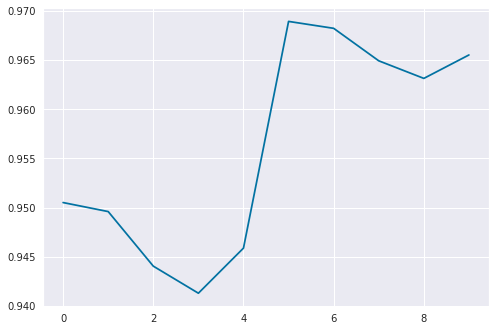

In [72]:
for train_index,test_index in skf.split(temp,target):
        xtrain,xtest = temp[temp.index.isin(train_index)],temp[temp.index.isin(test_index)]
        ytrain,ytest = target[train_index],target[test_index]
        
        model  = LogisticRegression(class_weight=class_weights)

        model.fit(xtrain,ytrain)
            
        preds = model.predict(xtest)
        
        print(f1_score(ytest,preds))
        scores.append(f1_score(ytest,preds))
        #
#
#        
print('-----------KFOLD--------------')
print(sns.lineplot(x=[i for i in range(len(scores))],y=scores))
print(min(scores),max(scores),np.mean(scores))

## Make Predictions on validation Data

In [45]:
final_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Question,Label,Label_enc
0,-1.280514,-0.479057,-0.074594,-1.078832,0.555026,-0.304828,0.710984,0.278825,0.129274,0.484494,0.194379,0.099252,0.048627,0.641369,0.453776,-0.550658,-0.685677,0.614255,-0.001949,-0.382198,-0.034112,0.072871,0.070514,-0.182452,-0.672063,-0.203226,0.207312,-0.494412,-0.015926,0.394312,0.036818,0.289581,0.572028,0.346302,-0.048939,0.285915,0.699641,0.078200,-0.658135,-0.720307,...,0.345353,-0.443688,0.326153,0.006781,-0.017737,0.361109,0.084457,-0.220593,-0.326400,0.109499,-0.313511,0.126476,-1.023944,0.019120,0.276654,0.090974,-0.871337,0.066085,0.055102,0.710251,0.815904,0.116723,-0.763052,-0.191135,-0.117060,-0.917495,0.238746,-0.721925,-0.708831,0.919504,0.014721,-0.218465,-0.707999,-0.060461,-0.690395,0.655525,0.429931,manner How did serfdom develop in and then lea...,DESC,0
1,0.050765,-0.231588,0.449181,-0.434117,-0.437005,-0.025377,0.901859,0.299691,0.397571,0.363239,0.813872,-0.242552,-0.046876,0.664556,0.063659,-0.778085,-0.464536,0.818348,0.217839,-0.682175,-0.048325,0.305595,0.005277,-0.105053,-0.850086,-0.180318,0.599913,-0.693823,-0.018519,0.129674,0.459312,0.366444,-0.351863,0.442381,0.333915,-0.367255,1.370850,-0.371237,-0.394274,0.127976,...,0.269263,-0.234702,0.203369,0.363199,0.800868,0.343576,0.986706,-0.211597,0.346223,-0.544377,0.259784,-0.261309,-0.354508,-0.033133,0.439806,0.176840,-0.155800,-1.046833,-0.140347,0.822187,1.090696,-0.127105,-1.281975,0.121476,-0.035387,-1.036540,-0.455563,-1.028529,-0.167688,-0.617333,-0.128335,-0.154140,0.052782,0.287510,-0.945878,0.582182,0.169365,cremat What films featured the character Popey...,FACT,1
2,0.165783,0.086285,0.996058,-0.007493,-0.062556,-0.447119,1.157736,-0.594608,-0.278915,0.288760,-0.755688,0.518912,-0.589018,-0.218036,-0.299750,-0.588890,-1.044726,0.417886,-0.516429,-0.688118,0.293211,0.023602,-0.186256,0.847153,-0.451656,0.414897,0.153552,-0.524880,0.480987,0.345679,0.525045,0.589052,-0.483123,0.143384,0.049669,-0.625910,1.300623,-0.494312,0.039376,-0.539757,...,-0.603539,-0.569769,0.099041,0.707026,0.829515,-0.109335,0.677547,0.197822,0.223959,-0.297395,-0.826129,-0.965579,-0.218842,1.487624,-0.247483,-0.609409,-0.065343,-0.464756,-0.134924,1.308985,0.461915,-0.319942,-0.315665,-0.672881,0.423251,-1.299873,-0.380740,-1.354729,-0.239816,-0.171938,0.529478,-0.135893,1.097948,-0.018599,-1.401098,-0.166925,-0.666989,manner How can I find a list of celebrities ' ...,DESC,0
3,-0.178117,-0.473958,0.048357,-1.291486,-0.028839,0.348842,-0.046128,0.052367,-0.436607,1.082325,1.379477,0.269814,-0.224944,0.555075,0.196508,-1.012059,-0.139680,0.013312,0.595400,-0.556999,-0.128182,0.313684,-0.397969,0.625162,-1.139045,0.605110,0.438818,-0.294600,-0.015436,-0.200387,-0.028176,0.543886,-0.501193,0.160218,-0.207827,-0.185351,0.511595,-0.588324,0.523014,-0.696837,...,-0.185516,-0.183404,0.793519,0.255796,0.518475,0.655393,0.389528,-0.159402,0.155687,-0.318774,-0.182897,-0.584351,-1.437036,0.627801,0.532542,0.662939,0.678888,-0.622288,0.319154,0.996853,0.696456,0.012059,-0.387256,0.541324,0.047869,-0.789448,-0.599024,-0.941752,0.158490,-0.710274,0.030269,0.281971,0.180029,0.274251,-0.035900,1.007164,-0.209413,animal What fowl grabs the spotlight after the...,FACT,1
4,-0.341517,-0.614352,0.075420,-0.381870,-0.037142,-0.639595,1.047396,1.109776,-0.500967,-0.308551,-0.026306,0.817466,0.180812,0.402919,0.446856,-0.506134,-0.852798,0.875699,-0.568851,-0.948410,0.342488,-0.257154,-0.041045,1.054365,0.182189,0.183331,0.685496,-0.191475,-0.196328,-0.376523,0.161194,-0.232624,-0.124186,0.408084,0.532743,-0.697111,-0.076796,-0.269128,-0.596582,-0.246367,...,-0.507654,-0.372031,0.384393,-0.427786,-0.062957,0.381885,-0.210031,-0.373227,0.138791,-0.295719,-0.431427,-0.521123,0.406644,0.222613,-0.5398

## Doing the split again to asociate the questions and corresponding labels with the training and validation sample

In [84]:
X_train,X_val,Y_train,Y_val = train_test_split(final_train.drop('Label_enc',axis=1),final_train['Label_enc'],test_size=0.15,stratify=final_train['Label_enc'],random_state=42)

In [85]:
X_val_new = X_val.drop(['Question','Label'],axis=1)

In [86]:
y_pred = model.predict(X_val_new)

In [87]:
len(y_pred )

818

## F1 Score

In [88]:
f1_score(y_pred,Y_val)

0.9852598913886733

## Confusion Matrix

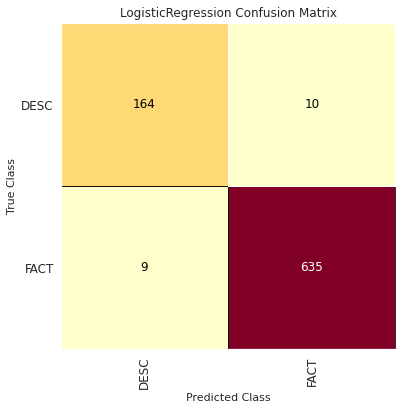

In [89]:
mapping = {0: "DESC", 1: "FACT"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    model,
    classes=["DESC", "FACT"],
    label_encoder=mapping,
)
cm_viz.score(X_val_new , Y_val)
cm_viz.poof()

## ROC -AUC Plot

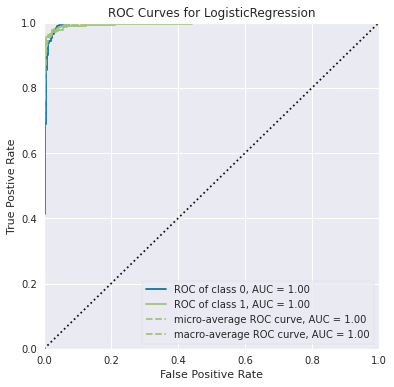

In [90]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(model)
roc_viz.score(X_val_new, Y_val)
roc_viz.poof()

## Retrieve Prediction Probabilities for Each Class

In [91]:
pred_proba = model.predict_proba(X_val_new)

In [92]:
pred_proba 

array([[1.61936774e-03, 9.98380632e-01],
       [1.63813071e-03, 9.98361869e-01],
       [1.70007900e-01, 8.29992100e-01],
       ...,
       [8.60555722e-05, 9.99913944e-01],
       [9.95827388e-01, 4.17261194e-03],
       [7.53098534e-04, 9.99246901e-01]])

## Store the prediction Probabilities into a DataFrame

In [93]:
df_pred = pd.DataFrame(pred_proba,columns=lb.classes_)

In [94]:
df_pred

,DESC,FACT
0,0.001619,0.998381
1,0.001638,0.998362
2,0.170008,0.829992
3,0.000734,0.999266
4,0.000603,0.999397
...,...,...
813,0.031017,0.968983
814,0.477337,0.522663
815,0.000086,0.999914
816,0.995827,0.004173


## Formatting the Validation Data

In [95]:
X_val[['Question','Label']]

,Question,Label
235,count How many revolutions does a standard LP ...,FACT
4503,ind Who shot Lee Harvey Oswald ?\n,FACT
2553,other Where in the Bible does it tell about Je...,FACT
627,city What Russian city boasts the Hermitage Mu...,FACT
3514,other What are some good medical sites for inf...,FACT
...,...,...
1254,product What kind of hat does Bat Masterson we...,FACT
3954,symbol What is the zodiac sign for August 14 ?\n,FACT
2656,count How many points are there on a Backgammo...,FACT
884,desc What are the living conditions in Cuba ?\n,DESC


In [96]:
predictions_made = X_val[['Question','Label']].copy()

In [97]:
predictions_made['Label_Predicted'] = y_pred

In [98]:
predictions_made.head()

,Question,Label,Label_Predicted
235,count How many revolutions does a standard LP ...,FACT,1
4503,ind Who shot Lee Harvey Oswald ?\n,FACT,1
2553,other Where in the Bible does it tell about Je...,FACT,1
627,city What Russian city boasts the Hermitage Mu...,FACT,1
3514,other What are some good medical sites for inf...,FACT,1


In [99]:
predictions_made['Label_Predicted'].unique()

array([1, 0])

## Generate Label Mapper

In [100]:
names = lb.classes_.tolist()

In [101]:
mapper = {k:v for k,v in enumerate(lb.classes_.tolist())}
mapper 

{0: 'DESC', 1: 'FACT'}

In [102]:
predictions_made['Label_Predicted'] = predictions_made['Label_Predicted'].map(mapper)

In [103]:
predictions_made.reset_index(inplace=True)

In [104]:
predictions_made = predictions_made.drop('index',axis=1)
predictions_made.head()

,Question,Label,Label_Predicted
0,count How many revolutions does a standard LP ...,FACT,FACT
1,ind Who shot Lee Harvey Oswald ?\n,FACT,FACT
2,other Where in the Bible does it tell about Je...,FACT,FACT
3,city What Russian city boasts the Hermitage Mu...,FACT,FACT
4,other What are some good medical sites for inf...,FACT,FACT


In [105]:
final_validation_preds = pd.concat((predictions_made,df_pred),axis=1)

In [106]:
final_validation_preds.head()

,Question,Label,Label_Predicted,DESC,FACT
0,count How many revolutions does a standard LP ...,FACT,FACT,0.001619,0.998381
1,ind Who shot Lee Harvey Oswald ?\n,FACT,FACT,0.001638,0.998362
2,other Where in the Bible does it tell about Je...,FACT,FACT,0.170008,0.829992
3,city What Russian city boasts the Hermitage Mu...,FACT,FACT,0.000734,0.999266
4,other What are some good medical sites for inf...,FACT,FACT,0.000603,0.999397


## Misclassified Labels after prediction

In [107]:
final_validation_preds[(final_validation_preds['Label'] == 'DESC')&(final_validation_preds['Label'] != final_validation_preds['Label_Predicted'])]

,Question,Label,Label_Predicted,DESC,FACT
67,reason What caused Shea & Gould to close their...,DESC,FACT,0.410790,0.589210
83,manner How do you make panoramic sugar eggs fo...,DESC,FACT,0.357325,0.642675
145,reason Why are the U.S. presidential elections...,DESC,FACT,0.149751,0.850249
152,desc What do a diamond and lump of coal have i...,DESC,FACT,0.379885,0.620115
342,manner How do you exterminate bees that are in...,DESC,FACT,0.252307,0.747693
353,manner How do you do a bibliography with an un...,DESC,FACT,0.279709,0.720291
601,reason Why was the L.A. office of Shea and Gou...,DESC,FACT,0.350439,0.649561
636,desc What were the three prophecies the witche...,DESC,FACT,0.416376,0.583624
714,manner How is Abigail Arcane related to the vi...,DESC,FACT,0.383589,0.616411
748,manner How do they find an epicenter ?\n,DESC,FACT,0.323601,0.676399


##Make Predictions on unseen data sample - Prediction Pipeline

In [67]:
import pickle
import pandas as pd 
import numpy as np
from sentence_transformers import SentenceTransformer

## Save the LogisticRegression Model

In [68]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [70]:
import os
filename = "LogisticRegression.pkl"
folder  = "/content/drive/MyDrive/ZeonAI"
model_path = os.path.join(folder,filename)
pickle.dump(model, open(model_path, 'wb'))

## RandomForest Classifier

In [45]:
from sklearn.model_selection import GridSearchCV
grid_params = {'max_depth': [2,3,5,7,10],
               'n_estimators' :[200,250,300,350,500]}
estimator = RandomForestClassifier(class_weight={0:2.3451417,1:0.63549095},random_state=42)

In [46]:
gridcv = GridSearchCV(estimator=estimator, 
                      param_grid=grid_params,
                      scoring = 'f1',
                      verbose=10,
                      cv=5,
                       n_jobs=-1)


In [47]:
gridcv.fit(features,lbls)
print(gridcv.best_params_)
print(gridcv.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 20.1min finished


{'max_depth': 10, 'n_estimators': 250}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 2.3451417, 1: 0.63549095},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


0.9088901159580343
0.9077936333699231
0.9180509413067551
0.9146945514584481
0.9217002237136465
-----------KFOLD--------------
AxesSubplot(0.125,0.125;0.775x0.755)
0.9077936333699231 0.9217002237136465 0.9142258931613615


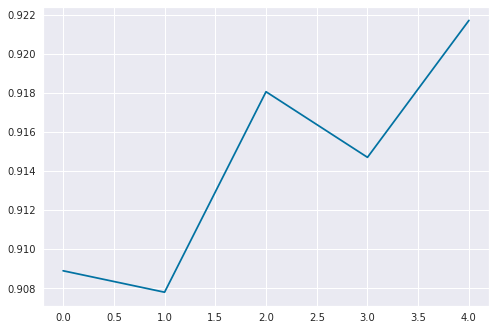

In [48]:
for train_index,test_index in skf.split(temp,target):
        xtrain,xtest = temp[temp.index.isin(train_index)],temp[temp.index.isin(test_index)]
        ytrain,ytest = target[train_index],target[test_index]
        
        model  = RandomForestClassifier( max_depth=10,
                                        n_estimators=250,
                                        class_weight={0:2.3451417,1:0.63549095},
                                        random_state=42)

        model.fit(xtrain,ytrain)
            
        preds = model.predict(xtest)
        
        print(f1_score(ytest,preds))
        scores.append(f1_score(ytest,preds))
        #
#
#        
print('-----------KFOLD--------------')
print(sns.lineplot(x=[i for i in range(len(scores))],y=scores))
print(min(scores),max(scores),np.mean(scores))

In [55]:
y_pred = model.predict(X_val)
print(f'accuracy_score :{accuracy_score(y_pred,Y_val)}')
print(f'F1_score :{f1_score(y_pred,Y_val)}')

accuracy_score :0.9657701711491442
F1_score :0.978328173374613


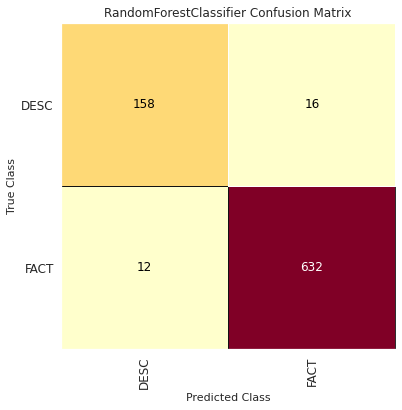

In [50]:
mapping = {0: "DESC", 1: "FACT"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    model,
    classes=["DESC", "FACT"],
    label_encoder=mapping,
)
cm_viz.score(X_val, Y_val)
cm_viz.poof()

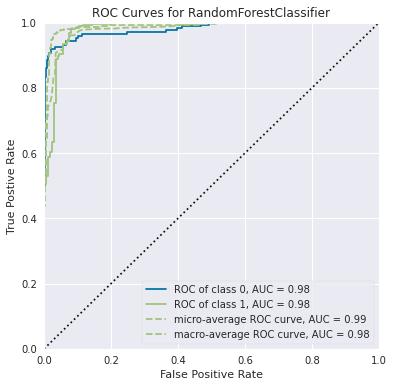

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(model)
roc_viz.score(X_val, Y_val)
roc_viz.poof()

* LogisticRegression scored better : 98.52%

* RandomForestClassifier scored : 97.83%

## Define The Prediction Pipeline

In [ ]:
class process_test_data():
  def __init__(self,file_path,model_path,mapper):
    self.file_path = file_path
    self.model_path = model_path
    self.mapper = mapper
  def read_data(self):
    self.TEST = pd.read_excel(self.file_path)
    self.TEST = self.TEST.rename(columns={'Query':'Question'})
    print(self.TEST.shape)
  def generate_vectors(self):
    self.sentence_list = TEST.Question.values.tolist()
    model = SentenceTransformer('sentence-transformers/distilbert-base-nli-mean-tokens')
    embeddings = model.encode(self.sentence_list)
    print(len(embeddings))
    self.train_vector = pd.DataFrame(np.array(embeddings))
    print(self.train_vector.shape)
  def load_and_predict(self):
    loaded_model = pickle.load(open(self.model_path , 'rb'))
    predictions = loaded_model.predict(self.train_vector)
    pred_proba = loaded_model.predict_proba(self.train_vector)
    print(len(predictions))
    names = [ k for k in self.mapper.values()]
    self.proba = pd.DataFrame(pred_proba,columns=names)
    self.TEST['Predicted Labels'] = predictions
    self.TEST['Predicted Labels'] = self.TEST['Predicted Labels'].map(mapper)
    self.TEST = pd.concat([self.TEST,self.proba],axis=1)
    return self.TEST
 



## Instantiate Class and retrive the final predictions

In [ ]:
file_path = "/content/TestSet_QueryClassification.xlsx"
model_path = "/content/drive/MyDrive/AV_Hack/Logistic_regression.pkl"
mapper = {0: 'ABBR', 1: 'DESC', 2: 'ENTY', 3: 'HUM', 4: 'LOC', 5: 'NUM'}
testdata = process_test_data(file_path,model_path,mapper)
testdata.read_data()
testdata.generate_vectors()
df= testdata.load_and_predict()

(20, 3)
20
(20, 768)
20


In [ ]:
df.head()

,S.No.,Question,Actual Label,Predicted Labels,ABBR,DESC,ENTY,HUM,LOC,NUM
0,1,Who is Genpact's CEO ?,HUM,HUM,2.144840e-03,0.000738,0.000003,0.996844,0.000040,0.000231
1,2,What was the diluted earnings per share for Ge...,NUM,NUM,3.358860e-07,0.000081,0.208753,0.090547,0.000074,0.700545
2,3,What was the final verdict in Pralipsa Rout vs...,DESC,DESC,3.685663e-04,0.829172,0.035295,0.000720,0.000011,0.134433
3,4,What is the court’s’ notice number that allows...,NUM,ENTY,3.143958e-05,0.150287,0.836988,0.000925,0.008959,0.002809
4,5,What are the components in the monthly gross s...,DESC/ENTY,NUM,1.023865e-06,0.005718,0.004760,0.000311,0.000025,0.989185
